In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Load the MNIST Dataset

In [2]:
(x_train, y_train),(x_test, y_test) = keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  

x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

# Split the data into training and testing datasets
x_train, x_val, y_train, y_val = train_test_split(
	x_train, y_train, test_size = 1/6, random_state=42)

# Print the dataset sizes
print('x_train.shape =', x_train.shape)
print('y_train.shape =', y_train.shape)
print('x_val.shape =', x_val.shape)
print('y_val.shape =', y_val.shape)
print('x_test.shape =', x_test.shape)
print('y_test.shape =', y_test.shape)

x_train.shape = (50000, 28, 28, 1)
y_train.shape = (50000,)
x_val.shape = (10000, 28, 28, 1)
y_val.shape = (10000,)
x_test.shape = (10000, 28, 28, 1)
y_test.shape = (10000,)


## Define and Train ConvNet and Simple ANN

In [3]:
# Define a function to generate and complie the ConvNet
def make_conv_model():
    model = Sequential()
    
    model.add(Conv2D(filters = 10, kernel_size = (5,5),padding = 'Same', 
                activation ='relu', input_shape = (28,28,1)))
    model.add(Conv2D(filters = 10, kernel_size = (5,5),padding = 'Same', 
                activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(64, activation = "relu"))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation = "softmax"))
    
    model.compile(optimizer=keras.optimizers.Adam(),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'] ) 
    
    model.summary()
    return model

# Define a function to generate and complie the ANN
def make_dense_model():
    model = Sequential()
    
    model.add(Flatten(input_shape = (28,28,1)))
    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation = "softmax"))

    model.compile(optimizer=keras.optimizers.Adam(),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy']  ) 
    
    model.summary()
    return model

# Define the parameters for training the models
epochs = 30
batch_size = 86

In [4]:
simple_conv_model = make_conv_model()
simple_conv_history = simple_conv_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val), verbose=1)
simple_conv_test_loss, simple_conv_test_acc = simple_conv_model.evaluate(x_test, y_test)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 10)        260       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 10)        2510      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 10)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1960)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                125504    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

In [5]:
dense_model = make_dense_model()
dense_history = dense_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val),verbose=1)
dense_test_loss, dense_test_acc = dense_model.evaluate(x_test, y_test)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                2570      
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
________________________________________________

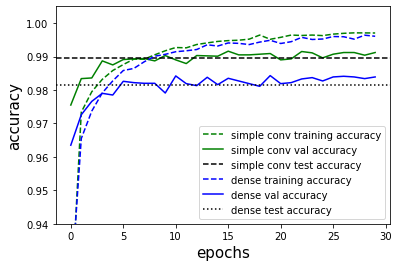

In [6]:
# Plot the accuracy curves of both models for training, evaluation and testing data
plt.plot(simple_conv_history.history["accuracy"], "g--",label="simple conv training accuracy")
plt.plot(simple_conv_history.history["val_accuracy"], "g-",label="simple conv val accuracy")
plt.axhline(simple_conv_test_acc,color="k", linestyle="--", label="simple conv test accuracy")

plt.plot(dense_history.history["accuracy"], "b--",label="dense training accuracy")
plt.plot(dense_history.history["val_accuracy"], "b-",label="dense val accuracy")
plt.axhline(dense_test_acc, color="k", linestyle=":", label="dense test accuracy")

plt.xlabel("epochs", fontsize=15)
plt.ylabel("accuracy", fontsize=15)
plt.ylim(0.94, 1.005)
plt.legend()

## Data Augmentation

In [7]:
# Perform data augmentation over the image datasets
datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False, 
         # set each sample mean to 0
        samplewise_center=False, 
        # divide inputs by std of the dataset
        featurewise_std_normalization=False, 
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,  
        # randomly rotate images by degrees
        rotation_range=10,  
        # Randomly zoom image
        zoom_range = 0.1,  
        # randomly shift images horizontally 
        width_shift_range=0.1,  
        # randomly shift images vertically 
        height_shift_range=0.1,  
        # randomly flip images
        horizontal_flip=False,  
        # randomly flip images
        vertical_flip=False)  

datagen.fit(x_train.reshape(-1,28,28,1))

In [8]:
simple_conv_model = make_conv_model()

simple_conv_aug_history = simple_conv_model.fit(
    datagen.flow(x_train,y_train, batch_size=batch_size),
    epochs = epochs, validation_data = (x_val,y_val),
    steps_per_epoch=x_train.shape[0]//batch_size, verbose=1)

simple_conv_aug_test_loss, simple_conv_aug_test_acc = simple_conv_model.evaluate(x_test, y_test)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 10)        260       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 10)        2510      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 10)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1960)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                125504    
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)               

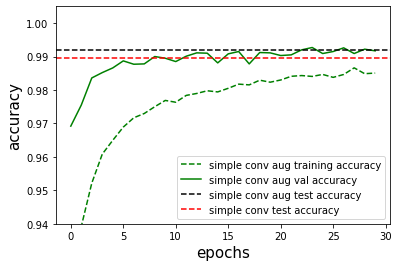

In [9]:
plt.plot(simple_conv_aug_history.history["accuracy"], "g--",label="simple conv aug training accuracy")
plt.plot(simple_conv_aug_history.history["val_accuracy"], "g-",label="simple conv aug val accuracy")
plt.axhline(simple_conv_aug_test_acc,color="k", linestyle="--", label="simple conv aug test accuracy")
plt.axhline(simple_conv_test_acc,color="r", linestyle="--", label="simple conv test accuracy")
plt.xlabel("epochs", fontsize=15)
plt.ylabel("accuracy", fontsize=15)
plt.ylim(0.94, 1.005)
plt.legend()